In [1]:
import spacy
import re
from pathlib import Path
import ftfy
import numpy as np
import sys
!{sys.executable} -m pip install python-louvain
!{sys.executable} -m pip install louvain
!{sys.executable} -m pip install spacy
!{sys.executable} -m pip install ftfy
!{sys.executable} -m pip install matplotlib


allnames_withliers=['Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Methusael', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Mizraim', 'Heth', 'Gether', 'Salah', 'Eber', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Haran', 'Lot', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Jokshan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Ishmael', 'Rachel', 'Bilhah', 'Levi', 'Jacob', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Deborah', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Ephron', 'Machir', 'Abraham', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Eleazar', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
allnames=['Pison', 'Hiddekel', 'Adam', 'Eve', 'Cain', 'Enoch', 'Irad', 'Lamech', 'Zillah', 'Seth', 'Enos', 'Methuselah', 'Noah', 'Canaan', 'Shem', 'Cush', 'Heth', 'Gether', 'Salah', 'Peleg', 'Jerah', 'Uzal', 'Diklah', 'Obal', 'Terah', 'Abram', 'Sarai', 'Shinab', 'Zoar', 'Dan', 'Sarah', 'Benammi', 'Nahor', 'Buz', 'Kemuel', 'Chesed', 'Jidlaph', 'Rebekah', 'Laban', 'Zimran', 'Medan', 'Sheba', 'Epher', 'Abidah', 'Isaac', 'Rachel', 'Bilhah', 'Levi', 'Asher', 'Reuben', 'Zebulun', 'Dinah', 'Joseph', 'Benjamin', 'Naphtali', 'Korah', 'Omar', 'Zepho', 'Zerah', 'Jaalam', 'Lotan', 'Shobal', 'Dishan', 'Samlah', 'Baalhanan', 'Mehetabel', 'Hirah', 'Onan', 'Pharez', 'Jachin', 'Shaul', 'Arodi', 'Malchiel', 'Belah', 'Jordan', 'Machir', 'Aaron', 'Jethro', 'Zipporah', 'Shimi', 'Elzaphan', 'Miriam', 'Hur', 'Joshua', 'Eliezer']
lg_allnames = len(allnames)

In [2]:
def get_index(list_name):
    """Return the list of indices, in the global list of names, of the names in list_name
    """
    list_index=[]

    for i in list_name:
        for j in range(lg_allnames):
            if(i==allnames[j]):
                list_index.append(j)

    return list_index

In [3]:
import numpy as np
def update_matrix(names, matrix_occ, matrix_diag):
    """Based on a list of names, update the matrix of occurence and the diagonal matrix
    Param
    -----------
    names : [str] List of names
    matrix_occ : [[int]] matrix containing 1 if 2 caracters been mentionned in a same verset
    matrix_diag : [[int]] matrix diagonal containing the degree of each nodes (the number of contacts with others characters)
    """
    if names:
        list_index = get_index(names)

        for i in range(len(list_index)-1):
            for j in range(i+1,len(list_index)):
                # Verify if the two characters not been mentionned in a same verset before
                if(matrix_occ[list_index[i]][list_index[j]]==0):
                    # Adding the fact that these two characters has been mentionned
                    matrix_occ[list_index[j]][list_index[i]]=1
                    matrix_occ[list_index[i]][list_index[j]]=1
                    # Add another new connection for the 2 characters
                    matrix_diag[list_index[i]][list_index[i]]+=1
                    matrix_diag[list_index[j]][list_index[j]]+=1
        
    return matrix_occ, matrix_diag

"""name_test = set(('Aaron', 'Hur', 'Benjamin'))
matrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"""

"name_test = set(('Aaron', 'Hur', 'Benjamin'))\nmatrix1, matrix2 = update_matrix(name_test,np.zeros((lg_allnames,lg_allnames)), np.zeros((lg_allnames,lg_allnames)))"

In [4]:
def extract_names(path):
    #names_by_verset={}
    NER = spacy.load("en_core_web_sm")
    # Load the text document in a list of verset
    doc = Path(path, encoding='cp1252').read_text(encoding='cp1252').split('\n\n')

    matrix_occ = np.zeros((lg_allnames, lg_allnames))
    matrix_diag = np.zeros((lg_allnames,lg_allnames))

    for i in range(len(doc)):
        # Preprocess and clean each verset
        doc[i]= re.sub(' +', ' ', ftfy.fix_text(doc[i]))
        doc[i]= re.sub('\n', ' ', doc[i])
        doc[i]= re.sub('\'', ' ', doc[i])

        # Init the key i to get all names present in the verset ith
        names_by_verset = []
        text1= NER(doc[i])

        # Incorpore each name once in the dictionnary at the ith position
        for word in text1.ents:
            if(word.label_ == "PERSON"):
                if(word.text in allnames):
                    if(word.text not in names_by_verset):
                        names_by_verset.append(word.text)

        matrix_occ, matrix_diag =update_matrix(names_by_verset, matrix_occ, matrix_diag)
    return matrix_occ, matrix_diag

matrix_occ, matrix_diag = extract_names('bible12_n.txt')

<ipython-input-5-9f165242ce4d>:14: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)


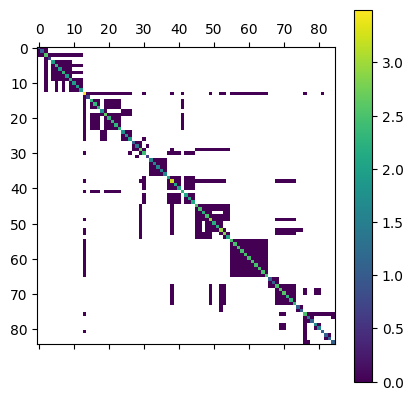

In [5]:
import matplotlib.pyplot as plt
def plot_matrix(matrix):


    for i in range (len(matrix)):
        for j in range (len(matrix)):

            if (i!=j):
                if (matrix[i][j]==0 ):
                    matrix[i][j] =1
                elif (matrix[i][j]==1 ):
                    matrix[i][j] =0

    matrix = np.log(matrix)
    plt.matshow(matrix)
    plt.colorbar()
    plt.show()

plot_matrix(matrix_diag-matrix_occ+1)

In [6]:
import networkx as nx
def create_graph(matrix):
    G = nx.Graph()


    G.add_nodes_from([i for i in range(lg_allnames)], weight = [matrix[i][i] for i in range(lg_allnames)])

    for j in range(lg_allnames-1):
        for k in range (j+1,lg_allnames,1):
            if(matrix_occ[j][k]!=0):
                G.add_edge(j,k)


    return G

graph_net = create_graph(matrix_diag+matrix_occ)
nx.draw(graph_net, nx.spring_layout(graph_net), node_color='black', node_size=20, width=0.5)
print(graph_net)

Graph with 85 nodes and 337 edges


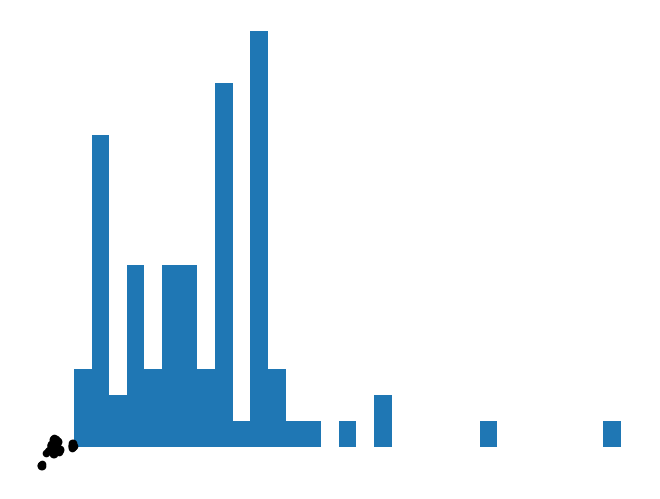

In [7]:
def display_histo(matrix):
    """Display a histo of the degree's frequencies
    """

    maximum = int(matrix.max())

    diagoV = [matrix[i][i] for i in range (len (matrix))]
    plt.hist(diagoV,bins = list(range(0,int(maximum)+1)))


    plt.show()

display_histo(matrix_diag)

In [8]:
!pip3 install python-louvain

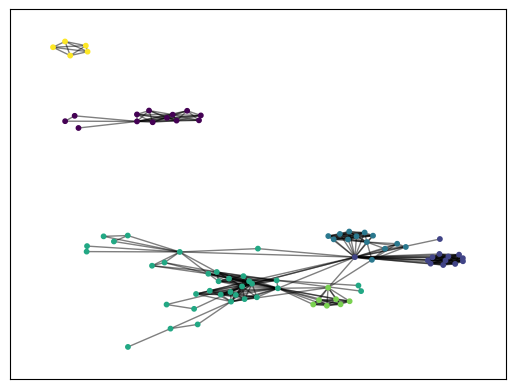

In [9]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

def louvain(G):

    partition = community_louvain.best_partition(G)


    pos = nx.spring_layout(G)
    # color the nodes according to their partition
    cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=10,cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

louvain(graph_net)

In [36]:
import time

In [103]:
pip install python-igraph

In [61]:
from igraph import Graph as graph

In [132]:
all_nodes = graph_net.nodes

In [140]:
def compute_independent_cascade(graph, seed_nodes, prob, n_iters=85):
    total_spead = 0
    
    # simulate the spread process over multiple runs
    for i in range(n_iters):
        np.random.seed(i)
        active = seed_nodes[:]
        new_active = seed_nodes[:]
        
        # for each newly activated nodes, find its neighbors that becomes activated
        while new_active:
            activated_nodes = []
            for node in new_active:
                neighbors = list(graph_net.neighbors(node))
                success = np.random.uniform(0, 1) < prob
                activated_nodes += list(np.extract(success, neighbors))

            # ensure the newly activated nodes doesn't already exist
            # in the final list of activated nodes before adding them
            # to the final list

            new_active = list(set(activated_nodes) - set(active))
            active += new_active

        total_spead += len(active)

    return total_spead / n_iters


# assuming we start with 1 seed node
seed_nodes = [0]
compute_independent_cascade(graph, seed_nodes, prob=0.5)


1.5529411764705883

In [141]:
def greedy(graph, k, prob=0., n_iters=1000):
    """
    Find k nodes with the largest spread (determined by IC) from a igraph graph
    using the Greedy Algorithm.
    """

    # we will be storing elapsed time and spreads along the way, in a setting where
    # we only care about the final solution, we don't need to record these
    # additional information

    elapsed = []
    spreads = []
    solution = []
    start_time = time.time()
    
    for _ in range(k):
        best_node = -1
        best_spread = -np.inf
        
        # loop over nodes that are not yet in our final solution
        # to find biggest marginal gain
        
        for node in all_nodes:
            spread = compute_independent_cascade(graph, solution + [node], prob, n_iters)
            if spread > best_spread:
                best_spread = spread
                best_node = node
                
        solution.append(best_node)
        spreads.append(best_spread)

        elapse = round(time.time() - start_time, 3)
        elapsed.append(elapse)

    return solution, spreads, elapsed

In [142]:
k = 4
prob = 0.2
n_iters = 85
greedy_solution, greedy_spreads, greedy_elapsed = greedy(graph_net, k, prob, n_iters)
print('solution: ', greedy_solution)
print('spreads: ', greedy_spreads)
print('elapsed: ', greedy_elapsed)

solution:  [2, 15, 29, 31]
spreads:  [1.2352941176470589, 2.4352941176470586, 3.6470588235294117, 4.964705882352941]
elapsed:  [0.255, 0.549, 1.148, 1.921]
